# Data visualisering 

## Loading relevant modules

Loading relevant modules and creating relevant (and relative) path. Feel free to change them.

In [1]:
from My_tools import DataFileLoader as DFL

import pandas as pd
import numpy as np

# imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer,KNNImputer
from sklearn.metrics import root_mean_squared_error

# visualising
import matplotlib.pyplot as plt 

# modeling
import statsmodels as sm 
import sklearn

In [2]:
ROOT = "../../"

PLOT_PATH = ROOT + "plots/"

DATA_PATH = ROOT + "data/"

METADATA_PRELOAD_DATA_PATH = ROOT + "PRIVATE_FILES/"

DATA_INFO = DATA_PATH + "info/"
DATA_INFO_NIBIO_FILE = DATA_INFO  + "lmt.nibio.csv"
DATA_INFO_FROST_FILE = DATA_INFO + "Frost_stations.csv"
DATA_INFO_NIBIO2FROST_FILE = DATA_INFO + "StationIDInfo.csv"
DATA_FILE_SOIL_STATIONS = DATA_INFO + "'Stasjonsliste jordtemperatur modellering.xlsx'"

DATA_COLLECTION = DATA_PATH + "raw_data/"
DATA_COLLECTION_STAT = DATA_COLLECTION + "Veret paa Aas 2013- 2017/" # pattern -> 'Veret paa Aas 2013- 2017/Veret paa Aas {YYYY}.pdf'
DATA_COLLECTION_TIME = DATA_COLLECTION + "Time 2013- 2023/" # pattern -> Time{YYYY}.xlsx
DATA_COLLECTION_NIBIO = DATA_COLLECTION + "nibio/" # pattern -> weather_data_hour_stID{id}_y{year}.csv
DATA_COLLECTION_MET = DATA_COLLECTION + "MET/" # pattern -> StationTo_{id}_FROM_{FrostID}.csv

# ID definitions
station_names = pd.read_csv(DATA_INFO_NIBIO_FILE,
                          header=0,
                          index_col = "ID")

nibio_id = {
    "Innlandet" : ["11","18","26","27"],
    "Trøndelag" : ["15","57","34","39"],
    "Østfold" : ["37","41","52","118"],
    "Vestfold" : ["30","38","42","50"] # Fjern "50" for å se om bedre resultat
}

## Fetching and ploting data

In [3]:
nibio_data_ungroup = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,r"weather_data_hour_stID(\d{1,3})_y(\d{4}).csv",_iter_key = True)
nibio_data_ungroup.load_data(names = ["Time","TM","RR","TJM10","TJM20"])
nibio_data = nibio_data_ungroup.group_layer(nibio_id)

nibio_data_raw_ungroup = DFL.DataFileLoader(DATA_COLLECTION_NIBIO,r"weather_data_raw_hour_stID(\d{1,3})_y(\d{4}).csv",_iter_key = True)
nibio_data_raw_ungroup.load_data(names = ["Time","TM","RR","TJM10","TJM20"])
nibio_data_raw = nibio_data_raw_ungroup.group_layer(nibio_id)

def dataframe_merge_func(x,y):
    y.iloc[y.iloc[:,1].notna() & (y.iloc[:,1] <= 0),2] = pd.NA
    x.iloc[0:y.shape[0],2] = y.iloc[0:y.shape[0],2]
    return x

imputed_nibio_data = nibio_data.combine(nibio_data_raw,merge_func = dataframe_merge_func)

### Ploting 


In [4]:
def avg_dataframe(*data_set): 
    data_set[0][1][0]["Time"] = data_set[0][1][0]["Time"].apply(lambda x: x.replace(year = 2000))
    average_data = data_set[0][1][0].fillna(0).set_index('Time') # initiates first data
    n = 1
    for _,station in data_set[1:]: # skips first since already accounted for 
        for data in station:
            data["Time"] = data["Time"].apply(lambda x: x.replace(year = 2000)) # to align all dataframes that spans over several years
            average_data = average_data.add(data.set_index('Time').subtract(average_data, fill_value=0).div(n+1)) 
            n += 1
        
    average_data = average_data.reset_index()
    return average_data

def differense(*data_set): 
    avg_data = avg_dataframe(*data_set)
    for _,station in data_set:
        for data in station:
            data["Time"] = data["Time"].apply(lambda x: x.replace(year = 2000))
    new_data_set = [(key,[data.set_index("Time").subtract(avg_data.set_index("Time")).reset_index() for data in station]) for key,station in data_set]
    return new_data_set

In [34]:
def heatmap_plot(diff_data,image_path,clear_plot = False):
    """
        Makes a heatmap of diff_data -> list[pd.DataFrame]
    """
    fig, ax = plt.subplots()

    cax = ax.matshow(
        arr := np.array([data.TJM20.to_numpy() for data in diff_data.values()]).transpose(),
        aspect='auto', cmap = "seismic"
    )

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(arr.shape[1]),
                  labels=list(diff_data.keys())
    )

    time_indexes = np.round(np.linspace(0, len(all_data[0][1][0].Time.to_numpy()) - 1, 10)).astype(int)
    ax.set_yticks(
        time_indexes,
        labels=np.array([d.strftime("%d-%m") for d in all_data[0][1][0].Time.to_numpy()])[time_indexes]
    )

    C = len(diff_data.keys())/(2* len(nibio_id.keys()))
    range = np.linspace(0,len(diff_data.keys()),num = len(nibio_id.keys())+1)
    # label the classes:
    sec = ax.secondary_xaxis(location=0)
    sec.set_xticks(range[:-1] + C - 0.5, labels=['{}'.format(region) for region in nibio_id.keys()])
    sec.tick_params('x', length=0)

    # lines between the classes:
    sec2 = ax.secondary_xaxis(location=0)
    sec2.set_xticks(range - 0.5, labels=[])
    sec2.tick_params('x', length=10, width=1.5)
    sec3 = ax.secondary_xaxis(location='top')
    sec3.set_xticks(range - 0.5, labels=[])
    sec3.tick_params('x', length=10, width=1.5)

    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
    #         rotation_mode="anchor")

    cbar = fig.colorbar(cax, label='Gradient')
    ax.set_title("Temperature difference from hourly average")
    ax.set_xlabel("\nStations")
    ax.set_ylabel("Date")
    #ax.set_aspect('equal', adjustable='datalim')
    plt.savefig(image_path)
    if clear_plot:
        plt.clf()

In [6]:
all_data = imputed_nibio_data.shave_top_layer().flatten(return_key = True) # [(key, value)]
#print(all_data)
diff_data = differense(*all_data)
diff_data = dict(diff_data)

In [24]:
np.array([data.TJM20.to_numpy() for data in diff_data]).transpose()

AttributeError: 'list' object has no attribute 'TJM20'

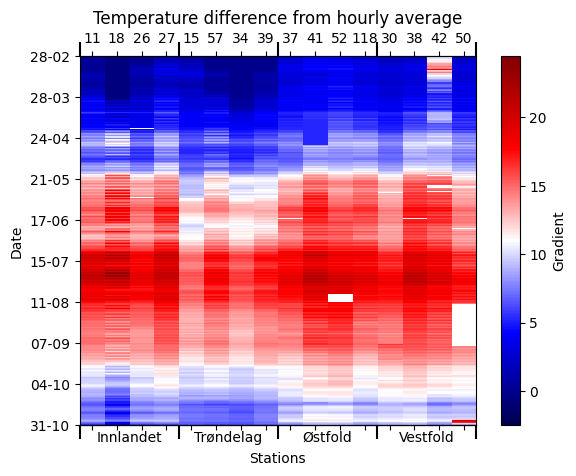

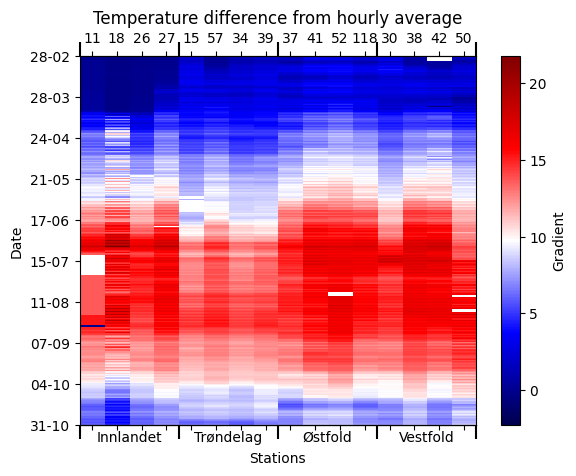

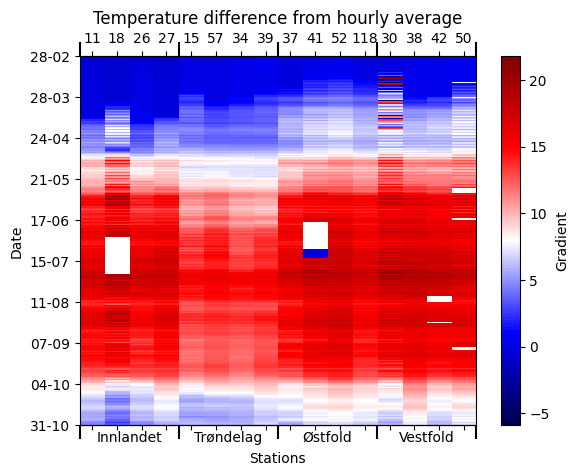

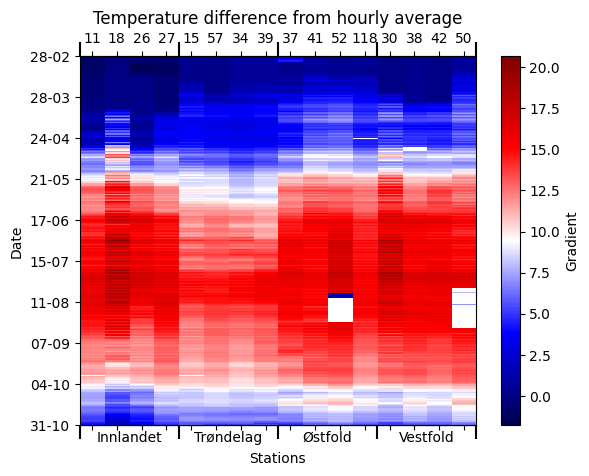

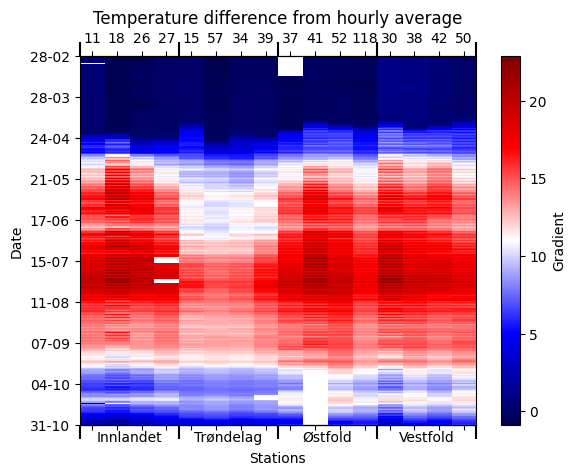

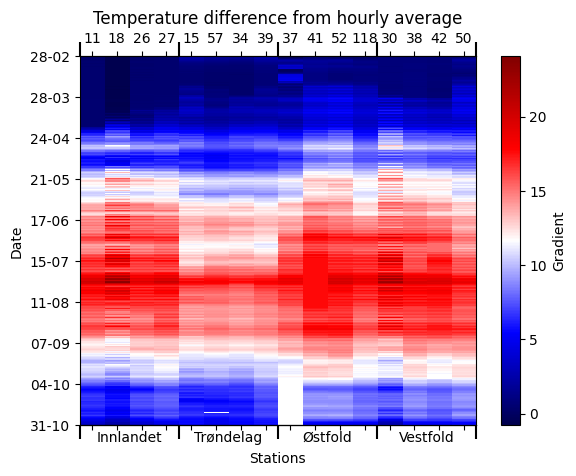

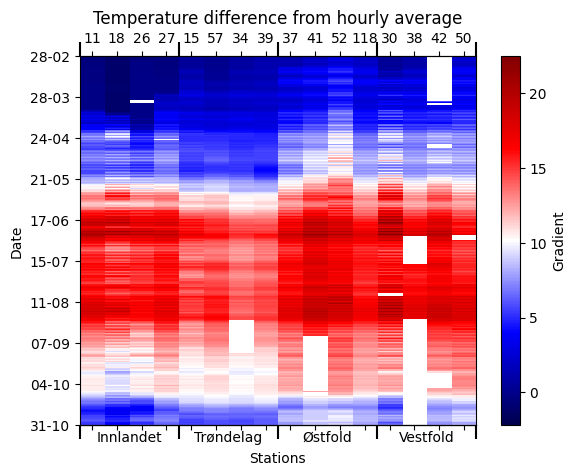

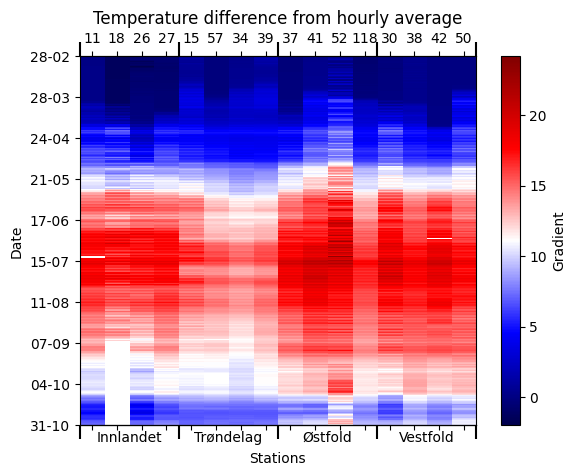

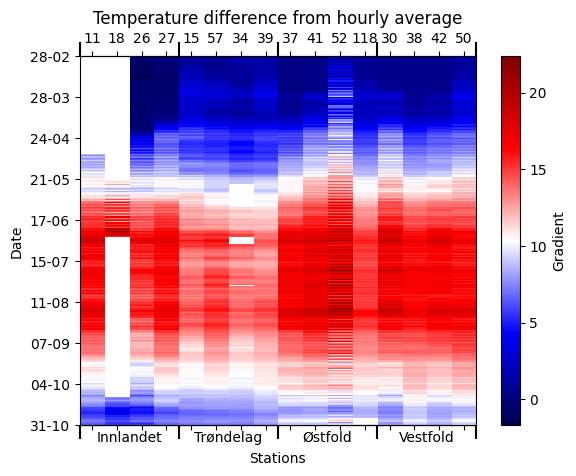

In [37]:
for y in range(9):
    heatmap_plot({key:data[y] for key,data in dict(all_data).items()},PLOT_PATH + "Plot_test_heatmap_y{}.pdf".format(2014+y))

In [43]:
sum(dict(all_data)["18"][-1].TJM20.isna())

4541

## Outlier detection

In [ ]:
def find_non_nan_ranges(df):
    """
    Finds the ranges of indexes where rows do not contain NaNs in the DataFrame.
    Assumes there is a 'Time' column with timestamps.

    Args:
        df (pd.DataFrame): Input DataFrame with NaNs.

    Returns:
        list of tuples: List of (start, end) index ranges where rows do not contain NaNs.
    """

    # Initialize variables
    non_nan_ranges = []
    start_idx = None

    # Iterate over rows
    for idx, row in df.iterrows():
        if not row.isna().any():
            # If the row does not contain NaNs
            if start_idx is None:
                # If this is the start of a new range
                start_idx = idx
        else:
            # If the row contains NaNs
            if start_idx is not None:
                # If this is the end of a range
                non_nan_ranges.append((start_idx, idx - 1))
                start_idx = None

    # Check if the last range is still open
    if start_idx is not None:
        non_nan_ranges.append((start_idx, df.index[-1]))

    return non_nan_ranges

In [7]:
"""
1. train a model to predict the training data and note the error from the prediction.
2. figure out the threshold from the error by figuring out the highest error.
3. isolate the points where this errer occured.

problems:
1. find Nan values and train around them.
2. Which model to use?
    1. LSTM

alternative:
1. temporal windowing
2. density based
"""
out_res = []

size_of_data = 0.4

print("Beginning imputation test")
for station_index, station in enumerate(np.random.choice(range(len(all_data)),size=len(all_data),replace = False)): # we randomly select a dataset to check
    current_data = all_data[station]
    if station_index >= int(size_of_data*len(all_data)): # checks if I have gone through a portion of the data
        break
    for k, (method,method_arguments) in enumerate(imputation_method): 
        max_range_1_unit = 0
        collected_mse = []
        print("Progress",(station_index*len(imputation_method)+k) / (int(size_of_data*len(all_data))*len(imputation_method)),end="\r")
        for span_start, span_end in find_non_nan_ranges(current_data): 
            for i in range(span_start,span_end):
                test = current_data.copy()
                test.loc[i:span_end-1,"TJM20"] = np.NaN # fills with missing values, except the last one
                imput_test = method(**method_arguments).fit_transform(test.loc[span_start:span_end,["RR","TM","TJM10","TJM20"]],current_data.loc[span_start:span_end,"TJM20"])
                if not(isinstance(imput_test,np.ndarray)):
                    imput_test = imput_test.to_numpy()
                score = root_mean_squared_error(current_data.loc[i:span_end,"TJM20"],
                                                imput_test[i-span_start:span_end-span_start+1,3]
                                               )
                collected_mse.append(score)
                if score <= 1 and (span_start - i + 1) > max_range_1_unit: 
                    max_range_1_unit = span_start - i + 1
        out_res.append((method.__name__,method_arguments,station_index,max_range_1_unit,span_start - max_range_1_unit,collected_mse))
print()
print("Ended imputation test")


## Imputing test

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5880
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1680.533
Date:                Tue, 19 Mar 2024   AIC                          -3359.066
Time:                        19:40:18   BIC                          -3352.387
Sample:                             0   HQIC                         -3356.744
                               - 5880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0331      0.000     78.901      0.000       0.032       0.034
Ljung-Box (L1) (Q):                4142.83   Jarque-Bera (JB):              2136.93
Prob(Q):                              0.00   Pr

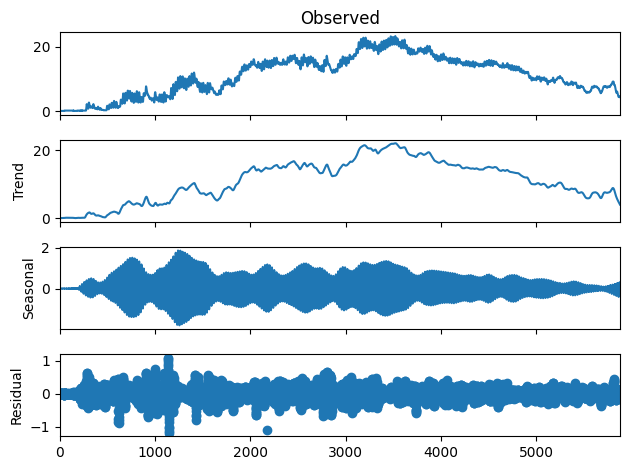

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import acf

alpha = all_data[0].TJM10.to_numpy().ravel().copy()
alpha[2174] = 13.8

print(ARIMA(alpha,order=(0,1,0)).fit().summary())

MSTL(alpha, periods=[24]).fit().plot()
plt.show()



In [57]:
all_data = imputed_nibio_data.flatten() # [DataFrame]

class STL_imputation:
    """
        Data to be imputed by decomposing it first then imuting missing values.
        Kwarg gets passed into MSTL.

        Strategy: Since MSTL cant handle Nan I will have to decompose the part I can and use imputation to connect the pices, then return the computed series.
    """
    def __init__(self, estimator = None, kwarg = {}):
        """
            estiamtor needs the 'fit_transform' and if estimator is a list it
            needs to be less or equal to the number of components (Trend, [Sesonal components], Residual),
            kwarg gets passed to estimator
        """
        assert estimator is not None, ValueError("Needs to spesify estimator")
        self.estimator = estimator
        self.params = kwarg

    def fit_transform(self,data,target = None):
        decompose = MSTL(data,**self.params)

class Pandas_imputation:
    def __init__(self, method = "fillna",kwargs={}):
        self.params = kwargs
        self.method = method

    def fit_transform(self, data,target = None):
        match self.method:
            case "fillna":
                return data.fillna(**self.params)
            case "interpolate":
                return data.interpolate(**self.params)
            case "ffill":
                return data.ffill(**self.params)
            case "bfill":
                return data.bfill(**self.params)
            case "mean":
                return data.fillna(data.mean(),**self.params)
            case _:
                raise ValueError("Did not reqonse '{}'".format(self.method))

imputation_method = [
    (SimpleImputer,{"strategy":"mean"}),
    (SimpleImputer,{"strategy":"most_frequent"}),
    (IterativeImputer,{}),
    (Pandas_imputation,{"method":"fillna","kwargs":{"value":0}}),
    (Pandas_imputation,{"method":"interpolate","kwargs":{"method":"linear"}}),
    (Pandas_imputation,{"method":"ffill","kwargs":{}}),
    (Pandas_imputation,{"method":"bfill","kwargs":{}}),
    (Pandas_imputation,{"method":"mean","kwargs":{}})
]

In [ ]:
imput_res = []

size_of_data = 0.4
number_of_allowed_fails = 15
fail_threshold = 3

print("Beginning imputation test")
for station_index, station in enumerate(np.random.choice(range(len(all_data)),size=len(all_data),replace = False)): # we randomly select a dataset to check
    current_data = all_data[station]
    if station_index >= int(size_of_data*len(all_data)): # checks if I have gone through a portion of the data
        break
    for k, (method,method_arguments) in enumerate(imputation_method): 
        max_range_1_unit = 0
        collected_mse = []
        print("Progress",(station_index*len(imputation_method)+k) / (int(size_of_data*len(all_data))*len(imputation_method)),end="\r")
        for span_start, span_end in find_non_nan_ranges(current_data): 
            if span_end-span_start+1 < 12:
                continue
            failed_attempts = 0
            for i in range(span_start+11,span_end):
                if failed_attempts > number_of_allowed_fails:
                    break
                test = current_data.copy()
                test.loc[i:span_end-1,"TJM20"] = np.NaN # fills with missing values, except the last one
                imput_test = method(**method_arguments).fit_transform(test.loc[span_start:span_end,["RR","TM","TJM10","TJM20"]],current_data.loc[span_start:span_end,"TJM20"])
                if not(isinstance(imput_test,np.ndarray)):
                    imput_test = imput_test.to_numpy()
                score = root_mean_squared_error(current_data.loc[i:span_end,"TJM20"],
                                                imput_test[i-span_start:span_end-span_start+1,3]
                                               )
                
                if score <= 1 and (span_start - i + 1) > max_range_1_unit: 
                    max_range_1_unit = span_start - i + 1
                    collected_mse.append(score)
                    failed_attempts = 0 # restarts fail counter
                if score > fail_threshold:
                    failed_attempts += 1
        imput_res.append((method.__name__,method_arguments,station_index,max_range_1_unit,span_start - max_range_1_unit,collected_mse))
print()
print("Ended imputation test")

Beginning imputation test


In [18]:
all_data[0].TJM20.to_numpy().ravel()[2170:2190]

array([13.6, 13.6, 13.7, 13.7,  nan, 13.9, 14. , 14.1, 14.2, 14.3, 14.3,
       14.3, 14.3, 14.3, 14.3, 14.2, 14.1, 14. , 13.9, 13.8])

In [56]:
method.__name__,method_arguments

('Pandas_imputation', {'method': 'bfill', 'kwargs': {}})